In [25]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [8]:
df_train = pd.read_csv('trainingSet.csv')
# df_test = pd.read_csv('testSet.csv').to_numpy()

df_shuffle = df_train.sample(random_state = 18, frac = 1)
df = df_shuffle.sample(random_state = 32, frac = 0.5)
df.reset_index(drop = True, inplace = True)

n_folds = 10
df_fold = []
breakpoints = []
for i in range(0, df.shape[0] + 1, int(df.shape[0] / n_folds)):
    breakpoints.append(i)
for i in range(len(breakpoints)-1):
    df_fold.append(df.iloc[breakpoints[i]:breakpoints[i+1]])
df_fold[9]

,gender,age,age_o,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,...,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,like,decision
2340,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,1,1,1
2341,1,0,0,1,1,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,1
2342,0,0,0,1,0,0,0,0,0,0,...,1,1,1,1,0,0,1,0,1,0
2343,1,0,0,1,0,0,0,0,0,0,...,1,1,1,1,0,1,1,1,1,1
2344,0,0,0,0,0,1,0,0,0,0,...,1,1,1,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,1,0,0,1,1,0,0,0,0,0,...,1,1,1,0,0,0,0,1,1,1
2596,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
2597,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,1,0
2598,0,0,0,1,0,0,0,0,0,0,...,1,1,1,1,1,1,0,1,1,1


In [19]:
class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None


class DecisionTreeClassifier:
    def __init__(self, max_depth=8, max_example = 50):
        self.max_depth = max_depth
        self.max_example = max_example
        
    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat)/y.size

    def _gini(self, y):
        m = y.size
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes_))

    def _best_split(self, X, y):
        m = y.size
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]

        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None

        for idx in range(self.n_features_):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))

            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):  # possible split positions
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )

                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr
    

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=self._gini(y),
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )


        if (depth <= self.max_depth) and (y.size >= self.max_example):
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node
    
    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

In [23]:
class BaggingDecisionTree:
    def __init__(self, n_trees=10, max_depth_outer=8, max_example = 50):
        self.n_trees_ = n_trees
        self.max_depth_outer = max_depth_outer
        self.max_example = max_example
        
    def fit(self, X, y):
        models = []
        data = np.c_[X,y]
        for i in range(self.n_trees_):
            data_sample = data[np.random.choice(X.shape[0], X.shape[0], replace=True), :]
            X_s = data_sample[:, :-1]
            y_s = data_sample[:, -1]
            clf = DecisionTreeClassifier(max_depth = self.max_depth_outer)
            clf.fit(X_s, y_s)
            models.append(clf)
            print(f'model {i} trained')
        self.models = models
        
    def predict(self, X):
        y_all_models = np.empty([X.shape[0], self.n_trees_])
        for i in range(self.n_trees_):
            y_all_models[:,i] = self.models[i].predict(X)
            
        y_hat = np.empty(X.shape[0])
        for i in range(X.shape[0]):
            y_hat[i] = self.find_majority(y_all_models[i,:])
        return y_hat

    def find_majority(self, votes):
        vote_count = Counter(votes)
        top_two = vote_count.most_common(2)
        if len(top_two)>1 and top_two[0][1] == top_two[1][1]:
            return 0
        return top_two[0][0]
        
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat)/y.size

In [22]:
class RandomForest:
        def __init__(self, n_trees=30, max_depth_outer=8, max_example = 50):
        self.n_trees_ = n_trees
        self.max_depth_outer = max_depth_outer
        self.max_example = max_example
        
        
    def fit(self, X, y):
        models = []
        data = np.c_[X,y]
        for i in range(self.n_trees_):
            data_sample = data[np.random.choice(X.shape[0], X.shape[0], replace=True), :]
            X_s = data_sample[:, :-1]
            y_s = data_sample[:, -1]
            clf = DecisionTreeSampleFeature(max_depth=self.max_depth_outer)
            clf.fit(X_s, y_s)
            models.append(clf)
#             print(f'model {i} trained')
        self.models = models
        
    def predict(self, X):
        y_all_models = np.empty([X.shape[0], self.n_trees_])
        for i in range(self.n_trees_):
            y_all_models[:,i] = self.models[i].predict(X)
            
        y_hat = np.empty(X.shape[0])
        for i in range(X.shape[0]):
            y_hat[i] = self.find_majority(y_all_models[i,:])
        return y_hat
        

    def find_majority(self, votes):
        vote_count = Counter(votes)
        top_two = vote_count.most_common(2)
        if len(top_two)>1 and top_two[0][1] == top_two[1][1]:
            return 0
        return top_two[0][0]
        
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat)/y.size


    


class DecisionTreeSampleFeature:
    def __init__(self, max_depth=8, max_example = 50):
        self.max_depth = max_depth
        self.max_example = max_example
        
    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat)/y.size

    def _gini(self, y):
        m = y.size
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes_))

    def _best_split(self, X, y):
        m = y.size
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]

        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None

        sample_features = np.random.choice(range(self.n_features_),math.isqrt(self.n_features_), replace=False)
        
        for idx in sample_features:
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))

            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):  # possible split positions
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )

                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr
    

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=self._gini(y),
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )


        if (depth <= self.max_depth) and (y.size >= self.max_example):
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node
    
    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 8)

In [26]:
d = np.array([3, 5, 7, 9])
accuracy = np.empty([3, n_folds, len(d)])

# for mode in range(1,4):
mode = 2
for i in range(n_folds):
    test_set = df_fold[i]
    X_test = test_set.drop(columns = ['decision']).to_numpy()
    y_test = test_set['decision'].to_numpy()

    train_set = df.drop(test_set.index)
    X_train = train_set.drop(columns = ['decision']).to_numpy()
    y_train = train_set['decision'].to_numpy()

    for j in range(len(d)):
        if mode == 1:
            clf = DecisionTreeClassifier(max_depth=j)
            clf.fit(X_train,y_train)
            s = clf.score(X_test,y_test)
            accuracy[mode-1][i][j] = s
        elif mode == 2:
            clf = BaggingDecisionTree(max_depth_outer=j)
            clf.fit(X_train,y_train)
            s = clf.score(X_test,y_test)
            accuracy[mode-1][i][j] = s
        elif mode == 3:
            clf = RandomForest(max_depth_outer=j)
            clf.fit(X_train,y_train)
            s = clf.score(X_test,y_test)
            accuracy[mode-1][i][j] = s
        else:
            print('mode error')
        

model 0 trained
model 1 trained
model 2 trained
model 3 trained
model 4 trained
model 5 trained
model 6 trained
model 7 trained
model 8 trained
model 9 trained
model 0 trained
model 1 trained
model 2 trained
model 3 trained
model 4 trained
model 5 trained
model 6 trained
model 7 trained
model 8 trained
model 9 trained
model 0 trained
model 1 trained
model 2 trained
model 3 trained
model 4 trained
model 5 trained
model 6 trained
model 7 trained
model 8 trained
model 9 trained
model 0 trained
model 1 trained
model 2 trained
model 3 trained
model 4 trained
model 5 trained
model 6 trained
model 7 trained
model 8 trained
model 9 trained
model 0 trained
model 1 trained
model 2 trained
model 3 trained
model 4 trained
model 5 trained
model 6 trained
model 7 trained
model 8 trained
model 9 trained
model 0 trained
model 1 trained
model 2 trained
model 3 trained
model 4 trained
model 5 trained
model 6 trained
model 7 trained
model 8 trained
model 9 trained
model 0 trained
model 1 trained
model 2 

In [54]:
ave = np.empty([3,len(d)])
sterr = np.empty([3,len(d)])

for i in range(0,1):    
    ave[i,:] = np.mean(accuracy[i], axis = 0)
    sterr[i,:] = np.std(accuracy[i], axis = 0) / np.sqrt(10)
    
ave[0]

array([0.69692308, 0.74153846, 0.73961538, 0.74346154])

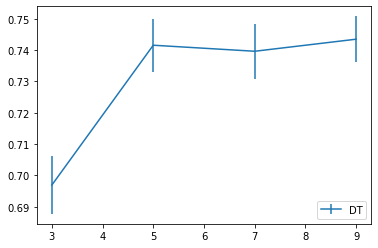

In [46]:
fig = plt.figure()
plt.errorbar(d, ave[0], yerr=sterr[0], label='DT')
plt.errorbar(d, ave[1], yerr=sterr[1], label='BT')
plt.errorbar(d, ave[2], yerr=sterr[2], label='RT')
plt.legend(loc='lower right')
# plt.savefig('accuracy.png', dpi = 150)
plt.show()


In [48]:
for mode in range(1,4):
    print(mode)

1
2
3
